# Paquetes

In [1]:
import os
import re
import ast
import optuna
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime
from sklearn.base import clone
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit, cross_val_score
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             balanced_accuracy_score, roc_auc_score, confusion_matrix)

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Funciones

In [2]:
def generar_diccionario_meses(num_meses=32, inicio=datetime(2008, 5, 1)):
    meses_en = ['January', 'February', 'March', 'April', 'May', 'June',
                'July', 'August', 'September', 'October', 'November', 'December']
    return {i + 1: f"{meses_en[(inicio.month - 1 + i) % 12]} {inicio.year + ((inicio.month - 1 + i) // 12)}"
        for i in range(num_meses)}

def cargar_y_preparar_datos(ruta_excel):
    data = pd.read_excel(ruta_excel, engine="openpyxl")
    data['ybin'] = data['y'].str.strip().str.lower().map(lambda x: 1 if x == "yes" else 0)
    data.drop(columns=['y'], inplace=True)
    meses = generar_diccionario_meses()
    data['Date'] = data['order'].astype(int).map(meses)
    return data.drop(columns=['month', 'order'])

def crear_datasets_por_mes(data, columna_fecha="Date", verbose=True):
    lista_datasets = []
    meses_dict = generar_diccionario_meses()
    meses = [meses_dict[i] for i in range(1, len(meses_dict) + 1) if meses_dict[i] in data[columna_fecha].values]
    for mes in meses:
        df_mes = data[data[columna_fecha] == mes]
        if not df_mes.empty:
            lista_datasets.append(df_mes)
            if verbose:
                print(f'Dataset: {mes} . Con tamaño: {len(df_mes)}')
    return lista_datasets

def filtrar_datasets_sin_2008(lista_datasets):
    lista_filtrada = []
    meses_eliminados = []
    for df in lista_datasets:
        fecha = df['Date'].iloc[0]
        if "2008" not in fecha:
            lista_filtrada.append(df)
        else:
            meses_eliminados.append(fecha)
    print(f"Se han eliminado los siguientes meses de 2008: {meses_eliminados}")
    return lista_filtrada

def estandarizar_datasets(lista_datasets, columna_fecha="Date"):
    all_columns_set = set()
    for df in lista_datasets:
        cat_cols = df.select_dtypes(include=['object', 'category']).drop(columns=[columna_fecha])
        dummies = pd.get_dummies(cat_cols, drop_first=True)
        all_columns_set.update(dummies.columns)

    all_dummy_columns = sorted(all_columns_set)
    datasets_homogeneos = []
    features_r = None

    for df in lista_datasets:
        df_numericas = df.select_dtypes(include='number')
        df_categoricas = df.select_dtypes(include=['object', 'category']).drop(columns=[columna_fecha])
        df_dummies = pd.get_dummies(df_categoricas, drop_first=True)
        for col in all_dummy_columns:
            if col not in df_dummies:
                df_dummies[col] = 0
        df_dummies = df_dummies[all_dummy_columns]
        df_final = pd.concat([df_dummies, df_numericas, df[columna_fecha]], axis=1)
        df_final.rename(columns={'ybin': 'Target'}, inplace=True)
        if features_r is None:
            features_r = [c for c in df_final.columns if c not in ['Target', columna_fecha]]
        datasets_homogeneos.append(df_final)

    return datasets_homogeneos, features_r

def calcular_proporciones_splits(splits, datasets):
    resultados = []
    for i, (train_range, val_range, test_range) in enumerate(splits, 1):
        train_size = sum(len(datasets[j]) for j in train_range)
        val_size = sum(len(datasets[j]) for j in val_range)
        test_size = sum(len(datasets[j]) for j in test_range)
        total = train_size + val_size + test_size
        print(f"Split {i}: Train={train_size}, Val={val_size}, Test={test_size}, Proporciones={train_size/total:.1%}/{val_size/total:.1%}/{test_size/total:.1%}")
        resultados.append((train_size, val_size, test_size))
    return resultados

def resumir_resultados_modelo(df_resultados, nombre_modelo=None, decimales=4):
    if nombre_modelo is None and 'Modelo' in df_resultados.columns:
        nombre_modelo = df_resultados['Modelo'].iloc[0]
    elif nombre_modelo is None:
        nombre_modelo = 'Modelo'
    columnas_excluir = ["Split", "Modelo"]
    columnas_a_excluir = [col for col in columnas_excluir if col in df_resultados.columns]
    resumen = df_resultados.drop(columns=columnas_a_excluir, errors='ignore').mean(numeric_only=True).round(decimales).to_dict()
    resumen_final = {"Modelo": nombre_modelo, **resumen}
    return pd.DataFrame([resumen_final])

# Espacios de búsqueda bayesiana por modelo
espacios_optimizacion = {
    'Regresión Logística': lambda trial: {
        'C': trial.suggest_float('C', 1e-5, 1e2, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': 'liblinear',
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    },
    'Árbol de Decisión': lambda trial: {
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy'])
    },
    'Random Forest': lambda trial: {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5)
    },
    'XGBoost': lambda trial: {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0)
    },
    'Red Neuronal': lambda trial: {
        'hidden_layer_sizes': trial.suggest_categorical(
            'hidden_layer_sizes',
            [(50,), (100,), (50, 50)]
        ),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh']),
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-1, log=True),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-1, log=True),
        'max_iter': trial.suggest_int('max_iter', 300, 3000),
        'early_stopping': True,
        'validation_fraction': trial.suggest_float('validation_fraction', 0.05, 0.25)
    }
}

modelos_config = {
    'Regresión Logística': LogisticRegression,
    'Árbol de Decisión': DecisionTreeClassifier,
    'Random Forest': RandomForestClassifier,
    'XGBoost': XGBClassifier,
    'Red Neuronal': MLPClassifier
}

def hyperparameter_tuning_completo(datasets, features_r, splits, n_trials=30):
    X_full = pd.concat([d[features_r] for d in datasets])
    y_full = pd.concat([d['Target'] for d in datasets])

    mejores_modelos = {}

    for nombre, modelo_class in modelos_config.items():
        print(f"\n--- Ajustando hiperparámetros para {nombre} ---")
        modelos_por_split = []

        for i, (_, val_range, _) in enumerate(splits, 1):
            # Construcción de PredefinedSplit
            mask = np.full(len(X_full), -1)
            start = 0
            for j, df in enumerate(datasets):
                end = start + len(df)
                if j in val_range:
                    mask[start:end] = 0
                start = end
            ps = PredefinedSplit(mask)

            # Definición de la función objetivo para Optuna
            def objective(trial):
                params = espacios_optimizacion[nombre](trial)                    
                modelo = modelo_class(**params)

                pipeline = Pipeline([
                    ('scaler', StandardScaler()),
                    ('modelo', modelo)
                ])

                score = cross_val_score(pipeline, X_full, y_full, cv=ps,
                                        scoring='f1_weighted', n_jobs=-1).mean()
                return score

            study = optuna.create_study(direction='maximize')
            study.optimize(objective, n_trials=n_trials)

            best_params = study.best_params
            best_score = study.best_value
            
            if nombre == 'Regresión Logística':
                best_params['solver'] = 'liblinear'
                
            if nombre == 'Red Neuronal':
                hls = best_params.get('hidden_layer_sizes')
                if isinstance(hls, (list, np.ndarray)):
                    best_params['hidden_layer_sizes'] = tuple(hls)

            # Entrenamiento final sobre los datos de train del split
            modelo_final = modelo_class(**best_params)
            modelo_final.fit(X_full[mask == -1], y_full[mask == -1])

            modelos_por_split.append(modelo_final)

            representacion = f"{modelo_class.__name__}(" + \
                ', '.join(f"{k}={repr(v)}" for k, v in best_params.items()) + ")"

            print(f"[Split {i}] Mejor F1: {best_score:.4f}")
            print(f"[Split {i}] Params: {representacion}")

        mejores_modelos[nombre] = modelos_por_split

    return mejores_modelos

def evaluar_modelo(nombre_modelo, datasets, features_r, splits,
                   modelo, modo="val", ajustado=None):
    """
    Evalúa un modelo en múltiples splits temporales con barra de progreso.

    Parámetros:
        nombre_modelo (str): Nombre del modelo.
        datasets (list): Lista de DataFrames, uno por mes.
        features_r (list): Lista de variables predictoras.
        splits (list): Lista de tuplas (train_range, val_range, test_range).
        modelo: Instancia del modelo (ya ajustado o por defecto).
        modo (str): "train", "val" o "test". Determina dónde se evalúa.
        ajustado (bool or None): Si es True/False, añade columna 'Ajustado'. Si None, no la incluye.

    Retorna:
        pd.DataFrame con métricas por split.
    """
    resultados = []

    for i, (train_range, val_range, test_range) in enumerate(tqdm(splits, desc=f"Evaluando {modo} - {nombre_modelo}"), 1):
        if modo == "train":
            train_indices = train_range
            eval_indices = train_range
        elif modo == "val":
            train_indices = train_range
            eval_indices = val_range
        elif modo == "test":
            train_indices = list(train_range) + list(val_range)
            eval_indices = test_range
        else:
            raise ValueError("El parámetro 'modo' debe ser 'train', 'val' o 'test'.")

        trainset = pd.concat(datasets[j] for j in train_indices)
        evalset = pd.concat(datasets[j] for j in eval_indices)

        X_train = trainset[features_r]
        y_train = trainset['Target']
        X_eval = evalset[features_r]
        y_eval = evalset['Target']

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clone(modelo))
        ])
        pipeline.fit(X_train, y_train)

        y_pred = pipeline.predict(X_eval)
        y_prob = pipeline.predict_proba(X_eval)[:, 1] if hasattr(pipeline, "predict_proba") else None

        fila = {
            "Split": f"Split {i}",
            "Modelo": nombre_modelo,
            "Accuracy": accuracy_score(y_eval, y_pred),
            "Precision": precision_score(y_eval, y_pred, zero_division=0),
            "Recall": recall_score(y_eval, y_pred, zero_division=0),
            "F1 Score": f1_score(y_eval, y_pred, zero_division=0),
            "Balanced Accuracy": balanced_accuracy_score(y_eval, y_pred)
        }

        if ajustado is not None:
            fila["Ajustado"] = "Sí" if ajustado else "No"

        resultados.append(fila)

    return pd.DataFrame(resultados)

def crear_grafico(df_base, df_ajustado, titulo_conjunto):
    """
    Crea gráficos comparativos entre modelos base y ajustados para un conjunto de datos.
    
    Parámetros:
    - df_base: DataFrame con métricas de modelos base (como resumen_test_base_df)
    - df_ajustado: DataFrame con métricas de modelos ajustados (como resumen_test_ajustados_df)
    - titulo_conjunto: Nombre del conjunto de datos (ej: "prueba", "validación", "entrenamiento")
    """
    # Copiar los DataFrames para no modificar los originales
    df_base = df_base.copy()
    df_ajustado = df_ajustado.copy()
    
    # Limpiar nombres de modelos (eliminar "(Base)" y "(Ajustado)")
    df_base['Modelo'] = df_base['Modelo'].apply(lambda x: re.sub(r'\s*\(.*\)', '', x))
    df_ajustado['Modelo'] = df_ajustado['Modelo'].apply(lambda x: re.sub(r'\s*\(.*\)', '', x))
    
    metricas = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Balanced Accuracy']
    
    df_base_melted = df_base.melt(id_vars="Modelo", value_vars=metricas, var_name="Métrica", value_name="Valor Métrica")
    
    df_ajustado_melted = df_ajustado.melt(id_vars="Modelo", value_vars=metricas, var_name="Métrica", value_name="Valor Métrica")

    # Gráfica comparativa
    #sns.set(style="white", context="paper", font_scale=1.2)
    #sns.set(style="darkgrid", palette="muted")
    #sns.set(style="whitegrid", context="talk", palette="bright")
    sns.set(style="whitegrid", palette="bright")
    fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

    # Gráfico 1: Modelos sin ajustar
    sns.barplot(data=df_base_melted, x="Métrica", y="Valor Métrica", hue="Modelo", ax=axes[0])
    axes[0].set_title("Modelos sin ajuste")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_ylim(0, 1.1)
    axes[0].grid(True, axis='y')
    axes[0].legend_.remove()

    # Gráfico 2: Modelos ajustados
    sns.barplot(data=df_ajustado_melted, x="Métrica", y="Valor Métrica", hue="Modelo", ax=axes[1])
    axes[1].set_title("Modelos con hiperparámetros ajustados")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_ylim(0, 1.1)
    axes[1].grid(True, axis='y')
    axes[1].legend_.remove()

    # Leyenda común
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=5, title="Modelos")

    # Título general
    plt.suptitle(f"Comparación de métricas en datos de {titulo_conjunto}", fontsize=16, y=1.12)
    plt.tight_layout(rect=[0, 0, 1, 1.00])
    plt.show()

# Cargar y preparar datos

In [3]:
# Cargar dataset
data = cargar_y_preparar_datos("DatosBancos.xlsx")

# Crear datasets por mes
lista_datasets = crear_datasets_por_mes(data)

# Eliminar meses de 2008
lista_datasets = filtrar_datasets_sin_2008(lista_datasets)

Dataset: May 2008 . Con tamaño: 6878
Dataset: June 2008 . Con tamaño: 4107
Dataset: July 2008 . Con tamaño: 5939
Dataset: August 2008 . Con tamaño: 5003
Dataset: October 2008 . Con tamaño: 50
Dataset: November 2008 . Con tamaño: 2852
Dataset: December 2008 . Con tamaño: 10
Dataset: March 2009 . Con tamaño: 228
Dataset: April 2009 . Con tamaño: 2191
Dataset: May 2009 . Con tamaño: 5097
Dataset: June 2009 . Con tamaño: 463
Dataset: July 2009 . Con tamaño: 313
Dataset: August 2009 . Con tamaño: 968
Dataset: September 2009 . Con tamaño: 207
Dataset: October 2009 . Con tamaño: 482
Dataset: November 2009 . Con tamaño: 1158
Dataset: December 2009 . Con tamaño: 172
Dataset: March 2010 . Con tamaño: 318
Dataset: April 2010 . Con tamaño: 441
Dataset: May 2010 . Con tamaño: 1794
Dataset: June 2010 . Con tamaño: 748
Dataset: July 2010 . Con tamaño: 922
Dataset: August 2010 . Con tamaño: 207
Dataset: September 2010 . Con tamaño: 363
Dataset: October 2010 . Con tamaño: 186
Dataset: November 2010 . C

In [4]:
data

,age,job,marital status,education,credit in default,housing loan,personal loan,contact,day week,duration,...,days without contact,number previous contacts,previous campaign result,employment variation rate,consumer price index,consumer confidence index,euribor,employees,ybin,Date
0,17,student,single,unknown,no,yes,no,cellular,wed,432,...,4,2,success,-2.9,92201.0,-31.4,884,5076.2,0,August 2009
1,17,student,single,basic.9y,no,yes,no,cellular,fri,182,...,999,2,failure,-2.9,92201.0,-31.4,869,5076.2,0,August 2009
2,17,student,single,basic.9y,no,yes,no,cellular,fri,92,...,4,2,success,-2.9,92201.0,-31.4,869,5076.2,0,August 2009
3,17,student,single,basic.9y,no,unknown,unknown,cellular,fri,498,...,999,1,failure,-2.9,92201.0,-31.4,869,5076.2,1,August 2009
4,17,student,single,unknown,no,no,yes,cellular,tue,896,...,2,2,success,-3.4,92431.0,-26.9,742,5017.5,1,October 2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,92,retired,married,unknown,no,no,yes,cellular,wed,370,...,3,4,success,-1.7,94027.0,-38.3,903,4991.6,1,August 2009
41184,94,retired,married,basic.9y,no,no,no,cellular,wed,134,...,999,1,failure,-3.4,92649.0,-30.1,716,5017.5,0,November 2009
41185,95,retired,divorced,basic.6y,no,no,no,cellular,thu,85,...,999,0,nonexistent,-1.8,92843.0,-50.0,165,5099.1,0,March 2010
41186,98,retired,married,basic.4y,unknown,yes,no,cellular,fri,476,...,2,2,success,-3.4,92431.0,-26.9,73,5017.5,1,October 2009


In [5]:
lista_datasets[0]

,age,job,marital status,education,credit in default,housing loan,personal loan,contact,day week,duration,...,days without contact,number previous contacts,previous campaign result,employment variation rate,consumer price index,consumer confidence index,euribor,employees,ybin,Date
6,18,student,single,high.school,no,yes,yes,cellular,tue,103,...,999,0,nonexistent,-1.8,92843.0,-50.0,1687,5099.1,0,March 2009
35,19,student,single,basic.6y,no,no,no,cellular,tue,136,...,999,0,nonexistent,-1.8,92843.0,-50.0,1556,5099.1,1,March 2009
86,20,student,single,basic.9y,no,yes,no,cellular,thu,325,...,999,0,nonexistent,-1.8,92843.0,-50.0,1538,5099.1,1,March 2009
87,20,student,single,basic.9y,no,yes,no,cellular,thu,267,...,999,0,nonexistent,-1.8,92843.0,-50.0,1538,5099.1,0,March 2009
161,21,student,single,high.school,no,no,no,cellular,tue,220,...,999,0,nonexistent,-1.8,92843.0,-50.0,1614,5099.1,1,March 2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41162,88,retired,divorced,basic.4y,no,yes,yes,cellular,wed,103,...,999,0,nonexistent,-1.8,92843.0,-50.0,1663,5099.1,0,March 2009
41163,88,retired,divorced,basic.4y,no,yes,yes,cellular,wed,82,...,999,0,nonexistent,-1.8,92843.0,-50.0,1663,5099.1,0,March 2009
41164,88,retired,divorced,basic.4y,no,yes,no,cellular,wed,188,...,999,0,nonexistent,-1.8,92843.0,-50.0,1663,5099.1,1,March 2009
41165,88,retired,divorced,basic.4y,no,no,no,cellular,wed,203,...,999,0,nonexistent,-1.8,92843.0,-50.0,1663,5099.1,1,March 2009


In [6]:
datasets = estandarizar_datasets(lista_datasets)
features_r = datasets[1]
datasets = datasets[0]

In [7]:
datasets[0]

,contact_telephone,credit in default_unknown,day week_mon,day week_thu,day week_tue,day week_wed,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,...,campaign,days without contact,number previous contacts,employment variation rate,consumer price index,consumer confidence index,euribor,employees,Target,Date
6,False,False,False,False,True,False,False,False,True,0,...,1,999,0,-1.8,92843.0,-50.0,1687,5099.1,0,March 2009
35,False,False,False,False,True,False,True,False,False,0,...,1,999,0,-1.8,92843.0,-50.0,1556,5099.1,1,March 2009
86,False,False,False,True,False,False,False,True,False,0,...,1,999,0,-1.8,92843.0,-50.0,1538,5099.1,1,March 2009
87,False,False,False,True,False,False,False,True,False,0,...,2,999,0,-1.8,92843.0,-50.0,1538,5099.1,0,March 2009
161,False,False,False,False,True,False,False,False,True,0,...,1,999,0,-1.8,92843.0,-50.0,1614,5099.1,1,March 2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41162,False,False,False,False,False,True,False,False,False,0,...,3,999,0,-1.8,92843.0,-50.0,1663,5099.1,0,March 2009
41163,False,False,False,False,False,True,False,False,False,0,...,2,999,0,-1.8,92843.0,-50.0,1663,5099.1,0,March 2009
41164,False,False,False,False,False,True,False,False,False,0,...,3,999,0,-1.8,92843.0,-50.0,1663,5099.1,1,March 2009
41165,False,False,False,False,False,True,False,False,False,0,...,2,999,0,-1.8,92843.0,-50.0,1663,5099.1,1,March 2009


In [8]:
# División temporal
splits = [
    (range(0, 7), range(7, 10), range(10, 13)),       # Split 1: 0-6 train, 7-9 val, 10-12 test
    (range(3, 10), range(10, 13), range(13, 16)),     # Split 2: 3-9 train, 10-12 val, 13-15 test
    (range(6, 13), range(13, 16), range(16, 19))      # Split 3: 6-12 train, 13-15 val, 16-18 test
]

calcular_proporciones_splits(splits, datasets)

# Modelos base
modelos_base = {
    "Regresión Logística": LogisticRegression,
    "Árbol de Decisión": DecisionTreeClassifier,
    "Random Forest": RandomForestClassifier,
    "XGBoost": XGBClassifier,
    "Red Neuronal": lambda: MLPClassifier(
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.1
    )
}

# Inicialización de diccionarios
resultados_train_base = {}
resumen_train_base = {}
resultados_train_ajustados = {}
resumen_train_ajustados = {}
resultados_val_base = {}
resumen_val_base = {}
resultados_val_ajustados = {}
resumen_val_ajustados = {}
resultados_test_base = {}
resumen_test_base = {}
resultados_test_ajustados = {}
resumen_test_ajustados = {}

Split 1: Train=9467, Val=1812, Test=2553, Proporciones=68.4%/13.1%/18.5%
Split 2: Train=3763, Val=2553, Test=1877, Proporciones=45.9%/31.2%/22.9%
Split 3: Train=4572, Val=1877, Test=640, Proporciones=64.5%/26.5%/9.0%


In [9]:
# Evaluación con modelos por defecto
for nombre_modelo, clase_modelo in modelos_base.items():
    modelo_base = modelos_base[nombre_modelo]()

    # Entrenamiento
    resultados = evaluar_modelo(nombre_modelo, datasets, features_r, splits,
                                modelo=modelo_base, modo="train", ajustado= False)
    resultados_train_base[nombre_modelo] = resultados
    resumen_train_base[nombre_modelo] = resumir_resultados_modelo(resultados, f"{nombre_modelo} (Base)")

    # Validación
    resultados = evaluar_modelo(nombre_modelo, datasets, features_r, splits,
                                modelo=modelo_base, modo="val", ajustado=False)
    resultados_val_base[nombre_modelo] = resultados
    resumen_val_base[nombre_modelo] = resumir_resultados_modelo(resultados, f"{nombre_modelo} (Base)")

    # Test
    resultados = evaluar_modelo(nombre_modelo, datasets, features_r, splits,
                                modelo=modelo_base, modo="test", ajustado=False)
    resultados_test_base[nombre_modelo] = resultados
    resumen_test_base[nombre_modelo] = resumir_resultados_modelo(resultados, f"{nombre_modelo} (Base)")

Evaluando test - Red Neuronal: 100%|█████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]


In [10]:
# Ajuste de hiperparámetros con optimización bayesiana
mejores_modelos_dict = hyperparameter_tuning_completo(datasets, features_r, splits, n_trials=500)


--- Ajustando hiperparámetros para Regresión Logística ---
[Split 1] Mejor F1: 0.7951
[Split 1] Params: LogisticRegression(C=0.03883009415357437, penalty='l1', max_iter=709, solver='liblinear')
[Split 2] Mejor F1: 0.8506
[Split 2] Params: LogisticRegression(C=0.03779343183541105, penalty='l1', max_iter=629, solver='liblinear')
[Split 3] Mejor F1: 0.8471
[Split 3] Params: LogisticRegression(C=7.351976038199525e-05, penalty='l2', max_iter=265, solver='liblinear')

--- Ajustando hiperparámetros para Árbol de Decisión ---
[Split 1] Mejor F1: 0.8029
[Split 1] Params: DecisionTreeClassifier(max_depth=4, min_samples_split=3, min_samples_leaf=3, criterion='gini')
[Split 2] Mejor F1: 0.8660
[Split 2] Params: DecisionTreeClassifier(max_depth=6, min_samples_split=8, min_samples_leaf=4, criterion='gini')
[Split 3] Mejor F1: 0.8806
[Split 3] Params: DecisionTreeClassifier(max_depth=3, min_samples_split=10, min_samples_leaf=2, criterion='gini')

--- Ajustando hiperparámetros para Random Forest ---


In [11]:
# Evaluación con modelos ajustados split a split
for nombre_modelo in modelos_base:
    resultados_train = []
    resultados_val = []
    resultados_test = []

    for i, split in enumerate(splits):
        modelo_ajustado = mejores_modelos_dict[nombre_modelo][i]

        # Train
        df_train = evaluar_modelo(nombre_modelo, datasets, features_r, [split],
                                  modelo=modelo_ajustado, modo="train", ajustado=True)
        resultados_train.append(df_train)

        # Validación
        df_val = evaluar_modelo(nombre_modelo, datasets, features_r, [split],
                                 modelo=modelo_ajustado, modo="val", ajustado=True)
        resultados_val.append(df_val)

        # Test
        df_test = evaluar_modelo(nombre_modelo, datasets, features_r, [split],
                                  modelo=modelo_ajustado, modo="test", ajustado=True)
        resultados_test.append(df_test)

    # Concatenación y resumen por conjunto
    resultados_train_ajustados[nombre_modelo] = pd.concat(resultados_train, ignore_index=True)
    resumen_train_ajustados[nombre_modelo] = resumir_resultados_modelo(
        resultados_train_ajustados[nombre_modelo], f"{nombre_modelo} (Ajustado)")

    resultados_val_ajustados[nombre_modelo] = pd.concat(resultados_val, ignore_index=True)
    resumen_val_ajustados[nombre_modelo] = resumir_resultados_modelo(
        resultados_val_ajustados[nombre_modelo], f"{nombre_modelo} (Ajustado)")

    resultados_test_ajustados[nombre_modelo] = pd.concat(resultados_test, ignore_index=True)
    resumen_test_ajustados[nombre_modelo] = resumir_resultados_modelo(
        resultados_test_ajustados[nombre_modelo], f"{nombre_modelo} (Ajustado)")

Evaluando test - Red Neuronal: 100%|█████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.95s/it]


In [12]:
# Concatenación final
resultados_train_base_df = pd.concat(resultados_train_base.values(), ignore_index=True)
resumen_train_base_df = pd.concat(resumen_train_base.values(), ignore_index=True)

resultados_train_ajustados_df = pd.concat(resultados_train_ajustados.values(), ignore_index=True)
resumen_train_ajustados_df = pd.concat(resumen_train_ajustados.values(), ignore_index=True)

resultados_val_base_df = pd.concat(resultados_val_base.values(), ignore_index=True)
resumen_val_base_df = pd.concat(resumen_val_base.values(), ignore_index=True)

resultados_val_ajustados_df = pd.concat(resultados_val_ajustados.values(), ignore_index=True)
resumen_val_ajustados_df = pd.concat(resumen_val_ajustados.values(), ignore_index=True)

resultados_test_base_df = pd.concat(resultados_test_base.values(), ignore_index=True)
resumen_test_base_df = pd.concat(resumen_test_base.values(), ignore_index=True)

resultados_test_ajustados_df = pd.concat(resultados_test_ajustados.values(), ignore_index=True)
resumen_test_ajustados_df = pd.concat(resumen_test_ajustados.values(), ignore_index=True)

In [13]:
resumen_total_df = pd.concat(
    [
        resumen_train_base_df.assign(Conjunto="Train Base"),
        resumen_train_ajustados_df.assign(Conjunto="Train Ajustado"),
        resumen_val_base_df.assign(Conjunto="Val Base"),
        resumen_val_ajustados_df.assign(Conjunto="Val Ajustado"),
        resumen_test_base_df.assign(Conjunto="Test Base"),
        resumen_test_ajustados_df.assign(Conjunto="Test Ajustado")
    ],
    ignore_index=True
)

# Regresión Logística

## Modelo base

### Train

In [14]:
resultados_train_base["Regresión Logística"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.848315,0.653930,0.348661,0.454822,0.653876,No
1,Split 2,Regresión Logística,0.752857,0.688792,0.495693,0.576503,0.690324,No
2,Split 3,Regresión Logística,0.830052,0.703991,0.554585,0.620420,0.738337,No


In [15]:
resumen_train_base["Regresión Logística"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Base),0.8104,0.6822,0.4663,0.5506,0.6942


### Validation

In [16]:
resultados_val_base["Regresión Logística"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.759382,0.582329,0.559846,0.570866,0.699552,No
1,Split 2,Regresión Logística,0.825695,0.573071,0.653558,0.610674,0.762391,No
2,Split 3,Regresión Logística,0.854555,0.714801,0.505102,0.591928,0.725952,No


In [17]:
resumen_val_base["Regresión Logística"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Base),0.8132,0.6234,0.5728,0.5912,0.7293


### Test

In [18]:
resultados_test_base["Regresión Logística"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.855464,0.806691,0.406367,0.540473,0.690306,No
1,Split 2,Regresión Logística,0.855621,0.748971,0.464286,0.573228,0.711604,No
2,Split 3,Regresión Logística,0.751563,0.684659,0.833910,0.751950,0.758835,No


In [19]:
resumen_test_base["Regresión Logística"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Base),0.8209,0.7468,0.5682,0.6219,0.7202


## Modelo ajustado

### Train

In [20]:
resultados_train_ajustados["Regresión Logística"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.847787,0.661988,0.329453,0.439953,0.646079,Sí
1,Split 1,Regresión Logística,0.746213,0.680089,0.476116,0.560111,0.680536,Sí
2,Split 1,Regresión Logística,0.755249,0.507665,0.751965,0.606125,0.754156,Sí


In [21]:
resumen_train_ajustados["Regresión Logística"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Ajustado),0.7831,0.6166,0.5192,0.5354,0.6936


### Validation

In [22]:
resultados_val_ajustados["Regresión Logística"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.764349,0.589391,0.579151,0.584226,0.708818,Sí
1,Split 1,Regresión Logística,0.844105,0.632296,0.608614,0.620229,0.757502,Sí
2,Split 1,Regresión Logística,0.836441,0.619718,0.561224,0.589023,0.735158,Sí


In [23]:
resumen_val_ajustados["Regresión Logística"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Ajustado),0.815,0.6138,0.583,0.5978,0.7338


### Test

In [24]:
resultados_test_ajustados["Regresión Logística"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.851939,0.754902,0.432584,0.550000,0.697719,Sí
1,Split 1,Regresión Logística,0.856153,0.747967,0.469388,0.576803,0.713818,Sí
2,Split 1,Regresión Logística,0.548438,0.500000,0.871972,0.635561,0.577012,Sí


In [25]:
resumen_test_ajustados["Regresión Logística"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Ajustado),0.7522,0.6676,0.5913,0.5875,0.6628


# Árbol de Decisión

## Modelo base

### Train

In [26]:
resultados_train_base["Árbol de Decisión"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Árbol de Decisión,1.0,1.0,1.0,1.0,1.0,No
1,Split 2,Árbol de Decisión,1.0,1.0,1.0,1.0,1.0,No
2,Split 3,Árbol de Decisión,1.0,1.0,1.0,1.0,1.0,No


In [27]:
resumen_train_base["Árbol de Decisión"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Árbol de Decisión (Base),1.0,1.0,1.0,1.0,1.0


### Validation

In [28]:
resultados_val_base["Árbol de Decisión"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Árbol de Decisión,0.633002,0.395448,0.536680,0.455364,0.604120,No
1,Split 2,Árbol de Decisión,0.581277,0.273880,0.606742,0.377402,0.590642,No
2,Split 3,Árbol de Decisión,0.816196,0.575080,0.459184,0.510638,0.684811,No


In [29]:
resumen_val_base["Árbol de Decisión"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Árbol de Decisión (Base),0.6768,0.4148,0.5342,0.4478,0.6265


### Test

In [30]:
resultados_test_base["Árbol de Decisión"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Árbol de Decisión,0.618096,0.295644,0.597378,0.395536,0.610477,No
1,Split 2,Árbol de Decisión,0.828450,0.588384,0.594388,0.591371,0.742312,No
2,Split 3,Árbol de Decisión,0.625000,0.579288,0.619377,0.598662,0.624503,No


In [31]:
resumen_test_base["Árbol de Decisión"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Árbol de Decisión (Base),0.6905,0.4878,0.6037,0.5285,0.6591


## Modelo ajustado

### Train

In [32]:
resultados_train_ajustados["Árbol de Decisión"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Árbol de Decisión,0.852963,0.701235,0.330617,0.449367,0.649694,Sí
1,Split 1,Árbol de Decisión,0.779166,0.729424,0.555208,0.630502,0.724708,Sí
2,Split 1,Árbol de Decisión,0.824584,0.636003,0.700437,0.666667,0.783250,Sí


In [33]:
resumen_train_ajustados["Árbol de Decisión"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Árbol de Decisión (Ajustado),0.8189,0.6889,0.5288,0.5822,0.7192


### Validation

In [34]:
resultados_val_ajustados["Árbol de Decisión"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Árbol de Decisión,0.747241,0.572464,0.457529,0.508584,0.660372,Sí
1,Split 1,Árbol de Decisión,0.758324,0.446034,0.642322,0.526477,0.715663,Sí
2,Split 1,Árbol de Decisión,0.857752,0.700965,0.556122,0.620199,0.746748,Sí


In [35]:
resumen_val_ajustados["Árbol de Decisión"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Árbol de Decisión (Ajustado),0.7878,0.5732,0.552,0.5518,0.7076


### Test

In [36]:
resultados_test_ajustados["Árbol de Decisión"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Árbol de Decisión,0.864473,0.688755,0.642322,0.664729,0.782776,Sí
1,Split 1,Árbol de Decisión,0.872136,0.694872,0.691327,0.693095,0.805596,Sí
2,Split 1,Árbol de Decisión,0.717187,0.621622,0.955017,0.753070,0.738192,Sí


In [37]:
resumen_test_ajustados["Árbol de Decisión"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Árbol de Decisión (Ajustado),0.8179,0.6684,0.7629,0.7036,0.7755


# Random Forest 

## Modelo base

### Train

In [38]:
resultados_train_base["Random Forest"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Random Forest,1.0,1.0,1.0,1.0,1.0,No
1,Split 2,Random Forest,1.0,1.0,1.0,1.0,1.0,No
2,Split 3,Random Forest,1.0,1.0,1.0,1.0,1.0,No


In [39]:
resumen_train_base["Random Forest"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Random Forest (Base),1.0,1.0,1.0,1.0,1.0


### Validation

In [40]:
resultados_val_base["Random Forest"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Random Forest,0.753863,0.566176,0.594595,0.580038,0.706107,No
1,Split 2,Random Forest,0.607521,0.318323,0.767790,0.450055,0.666461,No
2,Split 3,Random Forest,0.862014,0.738351,0.525510,0.614009,0.738176,No


In [41]:
resumen_val_base["Random Forest"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Random Forest (Base),0.7411,0.541,0.6293,0.548,0.7036


### Test

In [42]:
resultados_test_base["Random Forest"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Random Forest,0.723463,0.401376,0.655431,0.497866,0.698443,No
1,Split 2,Random Forest,0.865743,0.741379,0.548469,0.630499,0.748982,No
2,Split 3,Random Forest,0.759375,0.706422,0.799308,0.750000,0.762902,No


In [43]:
resumen_test_base["Random Forest"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Random Forest (Base),0.7829,0.6164,0.6677,0.6261,0.7368


## Modelo ajustado

### Train

In [44]:
resultados_train_ajustados["Random Forest"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Random Forest,0.968205,0.980339,0.841676,0.905731,0.918967,Sí
1,Split 1,Random Forest,0.910710,0.910201,0.817541,0.861386,0.888055,Sí
2,Split 1,Random Forest,0.949256,0.935176,0.856769,0.894257,0.918463,Sí


In [45]:
resumen_train_ajustados["Random Forest"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Random Forest (Ajustado),0.9427,0.9419,0.8387,0.8871,0.9085


### Validation

In [46]:
resultados_val_ajustados["Random Forest"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Random Forest,0.761589,0.580524,0.598456,0.589354,0.712674,Sí
1,Split 1,Random Forest,0.673717,0.370113,0.797753,0.505638,0.719332,Sí
2,Split 1,Random Forest,0.863079,0.743682,0.525510,0.615845,0.738849,Sí


In [47]:
resumen_val_ajustados["Random Forest"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Random Forest (Ajustado),0.7661,0.5648,0.6406,0.5703,0.7236


### Test

In [48]:
resultados_test_ajustados["Random Forest"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Random Forest,0.755582,0.445388,0.687266,0.540501,0.730458,Sí
1,Split 1,Random Forest,0.868940,0.757042,0.548469,0.636095,0.751002,Sí
2,Split 1,Random Forest,0.776563,0.710983,0.851211,0.774803,0.783155,Sí


In [49]:
resumen_test_ajustados["Random Forest"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Random Forest (Ajustado),0.8004,0.6378,0.6956,0.6505,0.7549


# XGBoost

## Modelo base

### Train

In [50]:
resultados_train_base["XGBoost"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,XGBoost,0.964614,0.942985,0.856810,0.897835,0.922662,No
1,Split 2,XGBoost,0.978209,0.979920,0.955364,0.967486,0.972654,No
2,Split 3,XGBoost,0.984471,0.974382,0.963319,0.968819,0.977428,No


In [51]:
resumen_train_base["XGBoost"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,XGBoost (Base),0.9758,0.9658,0.9252,0.9447,0.9576


### Validation

In [52]:
resultados_val_base["XGBoost"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,XGBoost,0.756071,0.559375,0.691120,0.618307,0.736595,No
1,Split 2,XGBoost,0.636898,0.336113,0.754682,0.465089,0.680214,No
2,Split 3,XGBoost,0.856153,0.684848,0.576531,0.626039,0.753248,No


In [53]:
resumen_val_base["XGBoost"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,XGBoost (Base),0.7497,0.5268,0.6741,0.5698,0.7234


### Test

In [54]:
resultados_test_base["XGBoost"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,XGBoost,0.692127,0.374000,0.700375,0.487614,0.695160,No
1,Split 2,XGBoost,0.864678,0.676923,0.673469,0.675192,0.794310,No
2,Split 3,XGBoost,0.748437,0.714765,0.737024,0.725724,0.747429,No


In [55]:
resumen_test_base["XGBoost"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,XGBoost (Base),0.7684,0.5886,0.7036,0.6295,0.7456


## Modelo ajustado

### Train

In [56]:
resultados_train_ajustados["XGBoost"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,XGBoost,0.882222,0.753574,0.521537,0.616443,0.741863,Sí
1,Split 1,XGBoost,0.813712,0.758528,0.661707,0.706817,0.776751,Sí
2,Split 1,XGBoost,0.886920,0.796226,0.737118,0.765533,0.837045,Sí


In [57]:
resumen_train_ajustados["XGBoost"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,XGBoost (Ajustado),0.861,0.7694,0.6401,0.6963,0.7852


### Validation

In [58]:
resultados_val_ajustados["XGBoost"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,XGBoost,0.778146,0.609023,0.625483,0.617143,0.732370,Sí
1,Split 1,XGBoost,0.687818,0.384345,0.818352,0.523040,0.735823,Sí
2,Split 1,XGBoost,0.864678,0.693820,0.630102,0.660428,0.778351,Sí


In [59]:
resumen_val_ajustados["XGBoost"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,XGBoost (Ajustado),0.7769,0.5624,0.6913,0.6002,0.7488


### Test

In [60]:
resultados_test_ajustados["XGBoost"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,XGBoost,0.847239,0.618033,0.705993,0.659091,0.795294,Sí
1,Split 1,XGBoost,0.871604,0.715100,0.640306,0.675639,0.786483,Sí
2,Split 1,XGBoost,0.756250,0.758755,0.674740,0.714286,0.749051,Sí


In [61]:
resumen_test_ajustados["XGBoost"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,XGBoost (Ajustado),0.825,0.6973,0.6737,0.683,0.7769


# Redes Neuronales

## Modelo base

### Train

In [62]:
resultados_train_base["Red Neuronal"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Red Neuronal,0.850322,0.684211,0.325378,0.441026,0.646042,No
1,Split 2,Red Neuronal,0.775711,0.725286,0.545810,0.622878,0.719808,No
2,Split 3,Red Neuronal,0.841864,0.731360,0.582533,0.648517,0.755521,No


In [63]:
resumen_train_base["Red Neuronal"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Red Neuronal (Base),0.8226,0.7136,0.4846,0.5708,0.7071


### Validation

In [64]:
resultados_val_base["Red Neuronal"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Red Neuronal,0.760486,0.572165,0.642857,0.605455,0.725215,No
1,Split 2,Red Neuronal,0.839405,0.623506,0.586142,0.604247,0.746266,No
2,Split 3,Red Neuronal,0.844433,0.685185,0.471939,0.558912,0.707350,No


In [65]:
resumen_val_base["Red Neuronal"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Red Neuronal (Base),0.8148,0.627,0.567,0.5895,0.7263


### Test

In [66]:
resultados_test_base["Red Neuronal"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Red Neuronal,0.860556,0.750000,0.500000,0.600000,0.727959,No
1,Split 2,Red Neuronal,0.860948,0.716172,0.553571,0.624460,0.747829,No
2,Split 3,Red Neuronal,0.765625,0.727869,0.768166,0.747475,0.765849,No


In [67]:
resumen_test_base["Red Neuronal"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Red Neuronal (Base),0.829,0.7313,0.6072,0.6573,0.7472


## Modelo ajustado

### Train

In [68]:
resultados_train_ajustados["Red Neuronal"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Red Neuronal,0.998521,0.996503,0.995343,0.995923,0.997285,Sí
1,Split 1,Red Neuronal,0.996280,0.993745,0.995301,0.994523,0.996042,Sí
2,Split 1,Red Neuronal,0.922135,0.802763,0.913537,0.854575,0.919272,Sí


In [69]:
resumen_train_ajustados["Red Neuronal"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Red Neuronal (Ajustado),0.9723,0.931,0.9681,0.9483,0.9709


### Validation

In [70]:
resultados_val_ajustados["Red Neuronal"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Red Neuronal,0.384658,0.248526,0.569498,0.346041,0.440081,Sí
1,Split 1,Red Neuronal,0.717195,0.396703,0.676030,0.500000,0.702057,Sí
2,Split 1,Red Neuronal,0.632925,0.329506,0.732143,0.454473,0.669438,Sí


In [71]:
resumen_val_ajustados["Red Neuronal"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Red Neuronal (Ajustado),0.5783,0.3249,0.6592,0.4335,0.6039


### Test

In [72]:
resultados_test_ajustados["Red Neuronal"]

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Red Neuronal,0.787701,0.493333,0.554307,0.522046,0.701869,Sí
1,Split 1,Red Neuronal,0.799148,0.516630,0.594388,0.552788,0.723793,Sí
2,Split 1,Red Neuronal,0.714063,0.652299,0.785467,0.712716,0.720369,Sí


In [73]:
resumen_test_ajustados["Red Neuronal"]

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Red Neuronal (Ajustado),0.767,0.5541,0.6447,0.5958,0.7153


# Resultados

## Train

In [74]:
resultados_train_base_df

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.848315,0.653930,0.348661,0.454822,0.653876,No
1,Split 2,Regresión Logística,0.752857,0.688792,0.495693,0.576503,0.690324,No
2,Split 3,Regresión Logística,0.830052,0.703991,0.554585,0.620420,0.738337,No
3,Split 1,Árbol de Decisión,1.000000,1.000000,1.000000,1.000000,1.000000,No
4,Split 2,Árbol de Decisión,1.000000,1.000000,1.000000,1.000000,1.000000,No
5,Split 3,Árbol de Decisión,1.000000,1.000000,1.000000,1.000000,1.000000,No
6,Split 1,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,No
7,Split 2,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,No
8,Split 3,Random Forest,1.000000,1.000000,1.000000,1.000000,1.000000,No
9,Split 1,XGBoost,0.964614,0.942985,0.856810,0.897835,0.922662,No


In [75]:
resultados_train_ajustados_df

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.847787,0.661988,0.329453,0.439953,0.646079,Sí
1,Split 1,Regresión Logística,0.746213,0.680089,0.476116,0.560111,0.680536,Sí
2,Split 1,Regresión Logística,0.755249,0.507665,0.751965,0.606125,0.754156,Sí
3,Split 1,Árbol de Decisión,0.852963,0.701235,0.330617,0.449367,0.649694,Sí
4,Split 1,Árbol de Decisión,0.779166,0.729424,0.555208,0.630502,0.724708,Sí
5,Split 1,Árbol de Decisión,0.824584,0.636003,0.700437,0.666667,0.783250,Sí
6,Split 1,Random Forest,0.968205,0.980339,0.841676,0.905731,0.918967,Sí
7,Split 1,Random Forest,0.910710,0.910201,0.817541,0.861386,0.888055,Sí
8,Split 1,Random Forest,0.949256,0.935176,0.856769,0.894257,0.918463,Sí
9,Split 1,XGBoost,0.882222,0.753574,0.521537,0.616443,0.741863,Sí


In [76]:
resumen_train_base_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Base),0.8104,0.6822,0.4663,0.5506,0.6942
1,Árbol de Decisión (Base),1.0000,1.0000,1.0000,1.0000,1.0000
2,Random Forest (Base),1.0000,1.0000,1.0000,1.0000,1.0000
3,XGBoost (Base),0.9758,0.9658,0.9252,0.9447,0.9576
4,Red Neuronal (Base),0.8226,0.7136,0.4846,0.5708,0.7071


In [77]:
resumen_train_ajustados_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Ajustado),0.7831,0.6166,0.5192,0.5354,0.6936
1,Árbol de Decisión (Ajustado),0.8189,0.6889,0.5288,0.5822,0.7192
2,Random Forest (Ajustado),0.9427,0.9419,0.8387,0.8871,0.9085
3,XGBoost (Ajustado),0.8610,0.7694,0.6401,0.6963,0.7852
4,Red Neuronal (Ajustado),0.9723,0.9310,0.9681,0.9483,0.9709


## Validation

In [78]:
resultados_val_base_df

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.759382,0.582329,0.559846,0.570866,0.699552,No
1,Split 2,Regresión Logística,0.825695,0.573071,0.653558,0.610674,0.762391,No
2,Split 3,Regresión Logística,0.854555,0.714801,0.505102,0.591928,0.725952,No
3,Split 1,Árbol de Decisión,0.633002,0.395448,0.536680,0.455364,0.604120,No
4,Split 2,Árbol de Decisión,0.581277,0.273880,0.606742,0.377402,0.590642,No
5,Split 3,Árbol de Decisión,0.816196,0.575080,0.459184,0.510638,0.684811,No
6,Split 1,Random Forest,0.753863,0.566176,0.594595,0.580038,0.706107,No
7,Split 2,Random Forest,0.607521,0.318323,0.767790,0.450055,0.666461,No
8,Split 3,Random Forest,0.862014,0.738351,0.525510,0.614009,0.738176,No
9,Split 1,XGBoost,0.756071,0.559375,0.691120,0.618307,0.736595,No


In [79]:
resultados_val_ajustados_df

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.764349,0.589391,0.579151,0.584226,0.708818,Sí
1,Split 1,Regresión Logística,0.844105,0.632296,0.608614,0.620229,0.757502,Sí
2,Split 1,Regresión Logística,0.836441,0.619718,0.561224,0.589023,0.735158,Sí
3,Split 1,Árbol de Decisión,0.747241,0.572464,0.457529,0.508584,0.660372,Sí
4,Split 1,Árbol de Decisión,0.758324,0.446034,0.642322,0.526477,0.715663,Sí
5,Split 1,Árbol de Decisión,0.857752,0.700965,0.556122,0.620199,0.746748,Sí
6,Split 1,Random Forest,0.761589,0.580524,0.598456,0.589354,0.712674,Sí
7,Split 1,Random Forest,0.673717,0.370113,0.797753,0.505638,0.719332,Sí
8,Split 1,Random Forest,0.863079,0.743682,0.525510,0.615845,0.738849,Sí
9,Split 1,XGBoost,0.778146,0.609023,0.625483,0.617143,0.732370,Sí


In [80]:
resumen_val_base_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Base),0.8132,0.6234,0.5728,0.5912,0.7293
1,Árbol de Decisión (Base),0.6768,0.4148,0.5342,0.4478,0.6265
2,Random Forest (Base),0.7411,0.5410,0.6293,0.5480,0.7036
3,XGBoost (Base),0.7497,0.5268,0.6741,0.5698,0.7234
4,Red Neuronal (Base),0.8148,0.6270,0.5670,0.5895,0.7263


In [81]:
resumen_val_ajustados_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Ajustado),0.8150,0.6138,0.5830,0.5978,0.7338
1,Árbol de Decisión (Ajustado),0.7878,0.5732,0.5520,0.5518,0.7076
2,Random Forest (Ajustado),0.7661,0.5648,0.6406,0.5703,0.7236
3,XGBoost (Ajustado),0.7769,0.5624,0.6913,0.6002,0.7488
4,Red Neuronal (Ajustado),0.5783,0.3249,0.6592,0.4335,0.6039


## Test

In [82]:
resultados_test_base_df

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.855464,0.806691,0.406367,0.540473,0.690306,No
1,Split 2,Regresión Logística,0.855621,0.748971,0.464286,0.573228,0.711604,No
2,Split 3,Regresión Logística,0.751563,0.684659,0.833910,0.751950,0.758835,No
3,Split 1,Árbol de Decisión,0.618096,0.295644,0.597378,0.395536,0.610477,No
4,Split 2,Árbol de Decisión,0.828450,0.588384,0.594388,0.591371,0.742312,No
5,Split 3,Árbol de Decisión,0.625000,0.579288,0.619377,0.598662,0.624503,No
6,Split 1,Random Forest,0.723463,0.401376,0.655431,0.497866,0.698443,No
7,Split 2,Random Forest,0.865743,0.741379,0.548469,0.630499,0.748982,No
8,Split 3,Random Forest,0.759375,0.706422,0.799308,0.750000,0.762902,No
9,Split 1,XGBoost,0.692127,0.374000,0.700375,0.487614,0.695160,No


In [83]:
resultados_test_ajustados_df

,Split,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Ajustado
0,Split 1,Regresión Logística,0.851939,0.754902,0.432584,0.550000,0.697719,Sí
1,Split 1,Regresión Logística,0.856153,0.747967,0.469388,0.576803,0.713818,Sí
2,Split 1,Regresión Logística,0.548438,0.500000,0.871972,0.635561,0.577012,Sí
3,Split 1,Árbol de Decisión,0.864473,0.688755,0.642322,0.664729,0.782776,Sí
4,Split 1,Árbol de Decisión,0.872136,0.694872,0.691327,0.693095,0.805596,Sí
5,Split 1,Árbol de Decisión,0.717187,0.621622,0.955017,0.753070,0.738192,Sí
6,Split 1,Random Forest,0.755582,0.445388,0.687266,0.540501,0.730458,Sí
7,Split 1,Random Forest,0.868940,0.757042,0.548469,0.636095,0.751002,Sí
8,Split 1,Random Forest,0.776563,0.710983,0.851211,0.774803,0.783155,Sí
9,Split 1,XGBoost,0.847239,0.618033,0.705993,0.659091,0.795294,Sí


In [84]:
resumen_test_base_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Base),0.8209,0.7468,0.5682,0.6219,0.7202
1,Árbol de Decisión (Base),0.6905,0.4878,0.6037,0.5285,0.6591
2,Random Forest (Base),0.7829,0.6164,0.6677,0.6261,0.7368
3,XGBoost (Base),0.7684,0.5886,0.7036,0.6295,0.7456
4,Red Neuronal (Base),0.8290,0.7313,0.6072,0.6573,0.7472


In [85]:
resumen_test_ajustados_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Ajustado),0.7522,0.6676,0.5913,0.5875,0.6628
1,Árbol de Decisión (Ajustado),0.8179,0.6684,0.7629,0.7036,0.7755
2,Random Forest (Ajustado),0.8004,0.6378,0.6956,0.6505,0.7549
3,XGBoost (Ajustado),0.8250,0.6973,0.6737,0.6830,0.7769
4,Red Neuronal (Ajustado),0.7670,0.5541,0.6447,0.5958,0.7153


In [86]:
resumen_total_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy,Conjunto
0,Regresión Logística (Base),0.8104,0.6822,0.4663,0.5506,0.6942,Train Base
1,Árbol de Decisión (Base),1.0000,1.0000,1.0000,1.0000,1.0000,Train Base
2,Random Forest (Base),1.0000,1.0000,1.0000,1.0000,1.0000,Train Base
3,XGBoost (Base),0.9758,0.9658,0.9252,0.9447,0.9576,Train Base
4,Red Neuronal (Base),0.8226,0.7136,0.4846,0.5708,0.7071,Train Base
5,Regresión Logística (Ajustado),0.7831,0.6166,0.5192,0.5354,0.6936,Train Ajustado
6,Árbol de Decisión (Ajustado),0.8189,0.6889,0.5288,0.5822,0.7192,Train Ajustado
7,Random Forest (Ajustado),0.9427,0.9419,0.8387,0.8871,0.9085,Train Ajustado
8,XGBoost (Ajustado),0.8610,0.7694,0.6401,0.6963,0.7852,Train Ajustado
9,Red Neuronal (Ajustado),0.9723,0.9310,0.9681,0.9483,0.9709,Train Ajustado


# Train - Validation - Test

## Modelos base

In [87]:
resumen_train_base_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Base),0.8104,0.6822,0.4663,0.5506,0.6942
1,Árbol de Decisión (Base),1.0000,1.0000,1.0000,1.0000,1.0000
2,Random Forest (Base),1.0000,1.0000,1.0000,1.0000,1.0000
3,XGBoost (Base),0.9758,0.9658,0.9252,0.9447,0.9576
4,Red Neuronal (Base),0.8226,0.7136,0.4846,0.5708,0.7071


In [88]:
resumen_val_base_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Base),0.8132,0.6234,0.5728,0.5912,0.7293
1,Árbol de Decisión (Base),0.6768,0.4148,0.5342,0.4478,0.6265
2,Random Forest (Base),0.7411,0.5410,0.6293,0.5480,0.7036
3,XGBoost (Base),0.7497,0.5268,0.6741,0.5698,0.7234
4,Red Neuronal (Base),0.8148,0.6270,0.5670,0.5895,0.7263


In [89]:
resumen_test_base_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Base),0.8209,0.7468,0.5682,0.6219,0.7202
1,Árbol de Decisión (Base),0.6905,0.4878,0.6037,0.5285,0.6591
2,Random Forest (Base),0.7829,0.6164,0.6677,0.6261,0.7368
3,XGBoost (Base),0.7684,0.5886,0.7036,0.6295,0.7456
4,Red Neuronal (Base),0.8290,0.7313,0.6072,0.6573,0.7472


## Modelos ajustados

In [90]:
resumen_train_ajustados_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Ajustado),0.7831,0.6166,0.5192,0.5354,0.6936
1,Árbol de Decisión (Ajustado),0.8189,0.6889,0.5288,0.5822,0.7192
2,Random Forest (Ajustado),0.9427,0.9419,0.8387,0.8871,0.9085
3,XGBoost (Ajustado),0.8610,0.7694,0.6401,0.6963,0.7852
4,Red Neuronal (Ajustado),0.9723,0.9310,0.9681,0.9483,0.9709


In [91]:
resumen_val_ajustados_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Ajustado),0.8150,0.6138,0.5830,0.5978,0.7338
1,Árbol de Decisión (Ajustado),0.7878,0.5732,0.5520,0.5518,0.7076
2,Random Forest (Ajustado),0.7661,0.5648,0.6406,0.5703,0.7236
3,XGBoost (Ajustado),0.7769,0.5624,0.6913,0.6002,0.7488
4,Red Neuronal (Ajustado),0.5783,0.3249,0.6592,0.4335,0.6039


In [92]:
resumen_test_ajustados_df

,Modelo,Accuracy,Precision,Recall,F1 Score,Balanced Accuracy
0,Regresión Logística (Ajustado),0.7522,0.6676,0.5913,0.5875,0.6628
1,Árbol de Decisión (Ajustado),0.8179,0.6684,0.7629,0.7036,0.7755
2,Random Forest (Ajustado),0.8004,0.6378,0.6956,0.6505,0.7549
3,XGBoost (Ajustado),0.8250,0.6973,0.6737,0.6830,0.7769
4,Red Neuronal (Ajustado),0.7670,0.5541,0.6447,0.5958,0.7153


# Gráficas comparativas

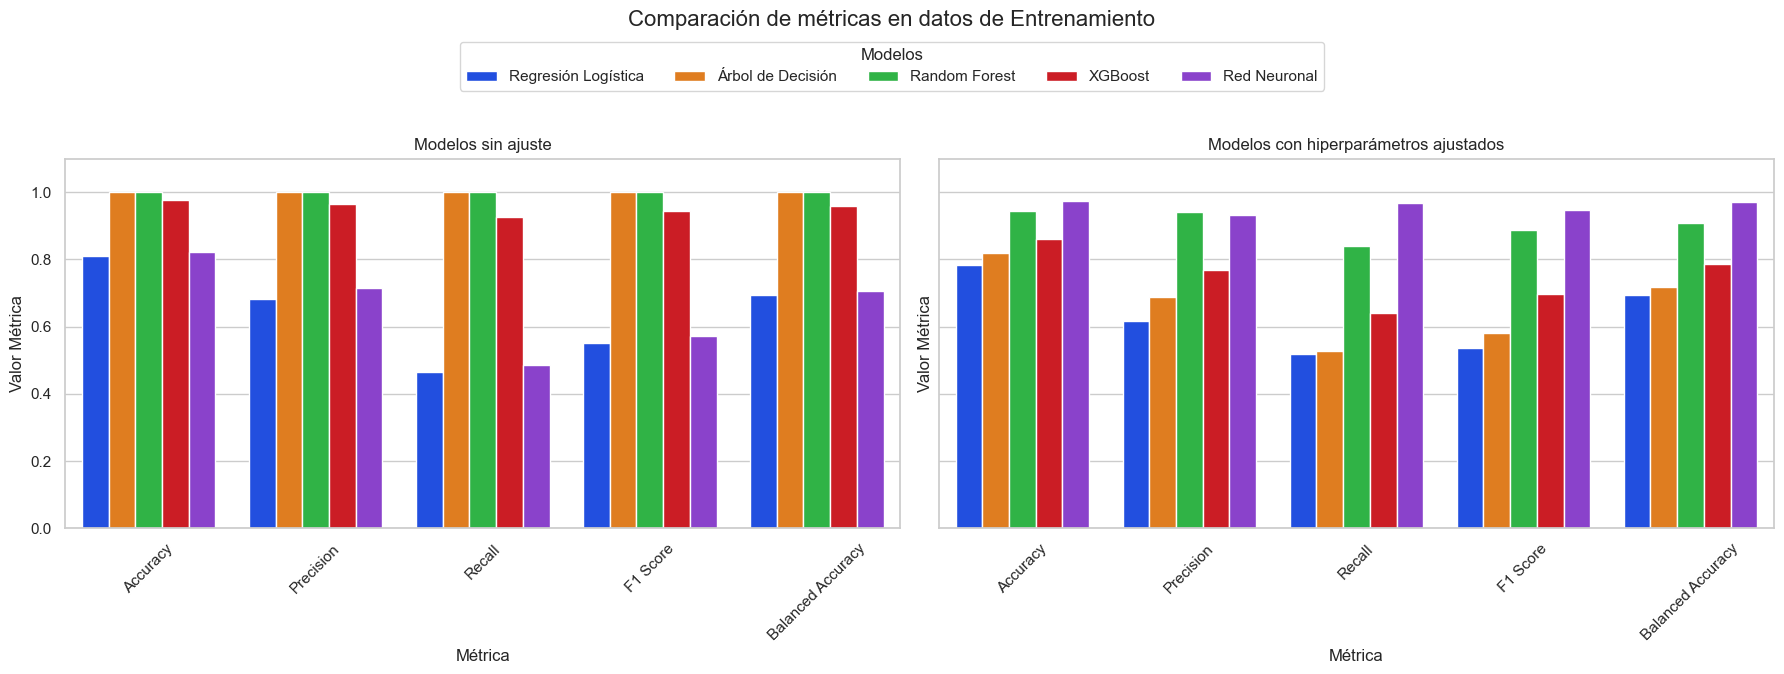

In [93]:
crear_grafico(resumen_train_base_df, resumen_train_ajustados_df, "Entrenamiento")

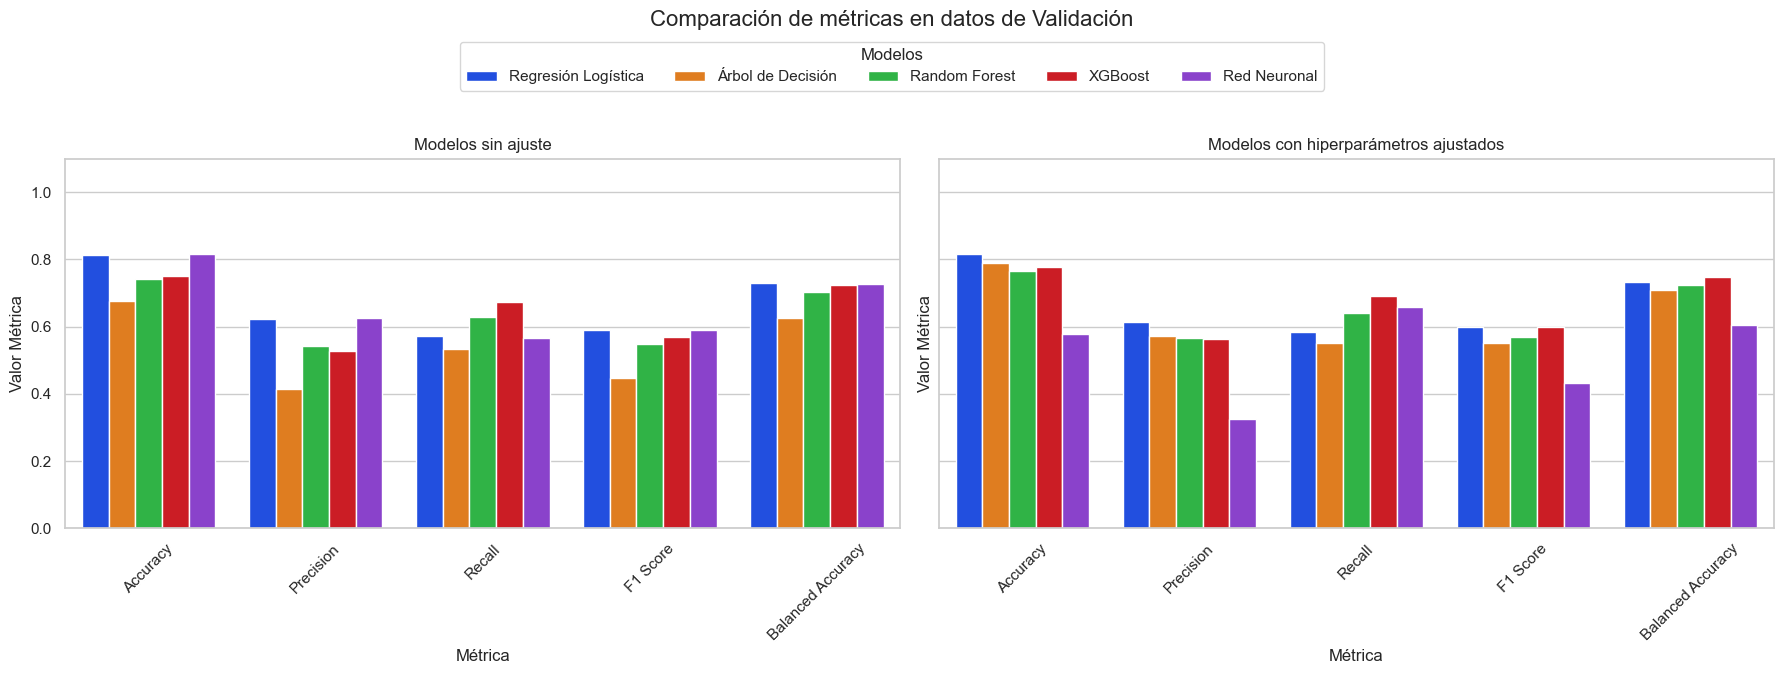

In [94]:
crear_grafico(resumen_val_base_df, resumen_val_ajustados_df, "Validación")

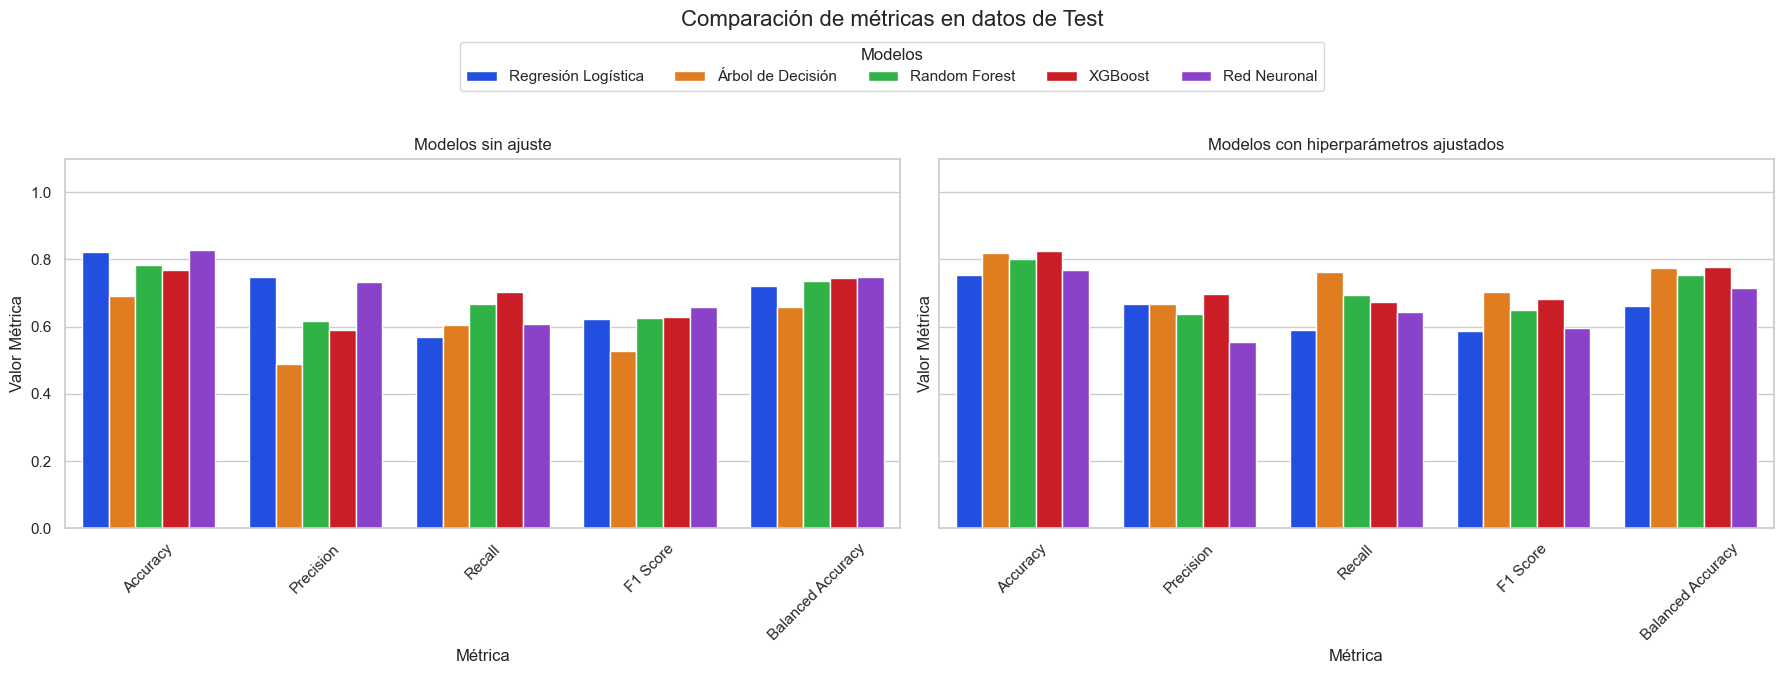

In [95]:
crear_grafico(resumen_test_base_df, resumen_test_ajustados_df, "Test")